In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import torch
from constrainednmf.nmf.models import NMF

%matplotlib inline

Text(0.5, 1.0, 'Components')

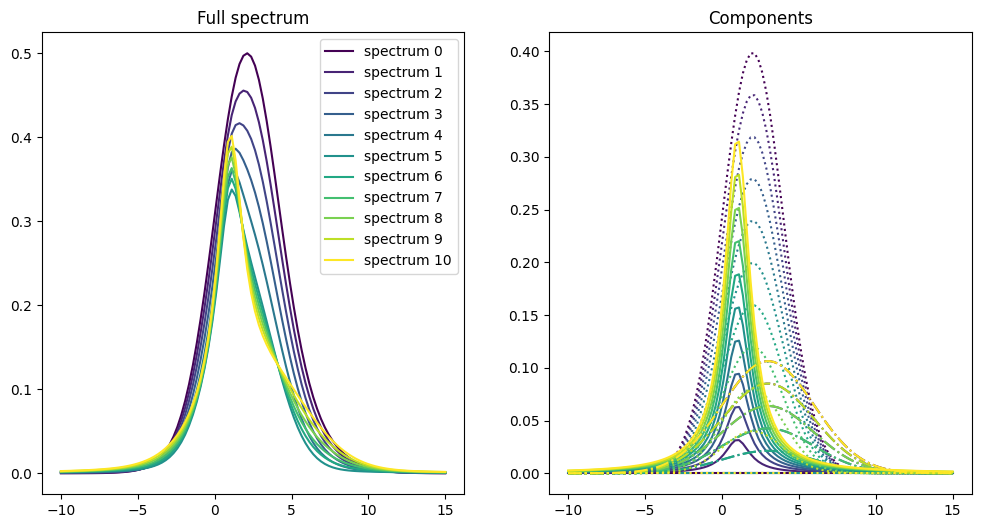

In [2]:
x = np.linspace(-10, 15, 100)

N_spectra = 11
amplitdues0 = np.linspace(0, 1, N_spectra)
amplitdues1 = np.linspace(2, 0, N_spectra)
amplitdues2 = np.abs(np.linspace(-0.8, 0.8, N_spectra))

colors = plt.cm.viridis(np.linspace(0, 1, N_spectra))

y0 = np.array([lorentzian(x, amplitude=amplitude, center=1, sigma=0.1*10)
               for amplitude in amplitdues0])

y1 = np.array([gaussian(x, amplitude=amplitude, center=2, sigma=.2*10)
               for amplitude in amplitdues1])

y2 = np.array([gaussian(x, amplitude=amplitude, center=3, sigma=.3*10)
               for amplitude in amplitdues2])

data = y0 + y1 + y2


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, (spectrum, color) in enumerate(zip(data, colors)):
    axs[0].plot(x, spectrum, color=color, label=f'spectrum {i}')

axs[0].legend()

for i, color in enumerate(colors):
    axs[1].plot(x, y0[i], '-', color=color)
    axs[1].plot(x, y1[i], ':',color=color)
    axs[1].plot(x, y2[i], linestyle='dashdot', color=color)

axs[0].set_title('Full spectrum')
axs[1].set_title('Components')

In [3]:
ideal_weights = np.array([amplitdues0, amplitdues1, amplitdues2])


input_W = [torch.tensor(w[None, :], dtype=torch.float) for w in ideal_weights.T]
model = NMF(data.shape,
          n_components=3,
          initial_weights=input_W,
          fix_weights=[True for _ in range(len(input_W))]
         )
n_iter = model.fit(torch.tensor(data), beta=2, tol=1e-10, max_iter=10000)
H = model.H.data.numpy()
W = model.W.data.numpy()

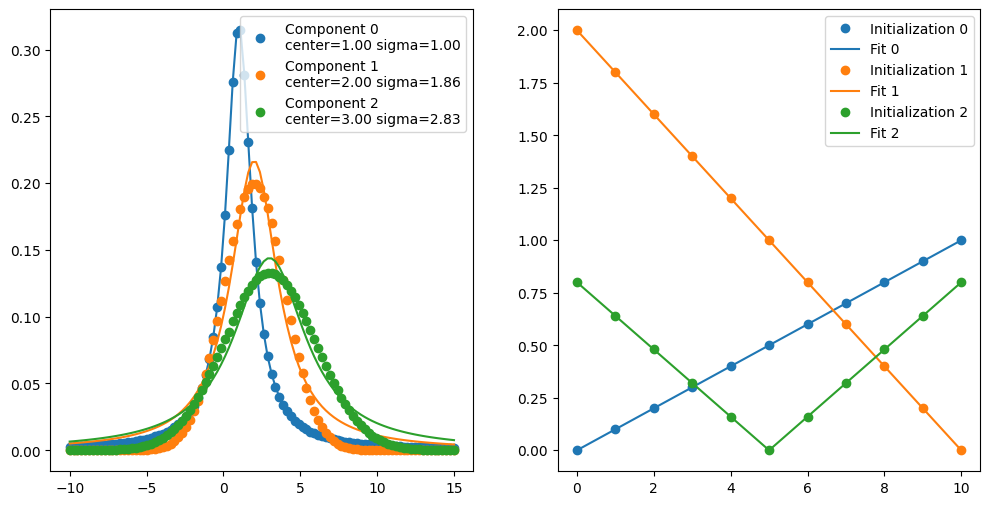

In [4]:
model = lmfit.models.LorentzianModel()

results = []

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, h in enumerate(H):
    result = model.fit(h, x=x)
    center = result.best_values['center']
    sigma = result.best_values['sigma']
    axs[0].plot(x, h, 'o', color=f'C{i}', label=f'Component {i}\ncenter={center:.2f} sigma={sigma:.2f}')
    axs[0].plot(x, result.best_fit, '-', color=f'C{i}')
    
    results.append(result)

axs[0].legend()

for i, (w, w_ideal) in enumerate(zip(W.T, ideal_weights)):
    axs[1].plot(w_ideal, 'o', color=f'C{i}',  label=f'Initialization {i}')
    axs[1].plot(w, '-', color=f'C{i}', label=f'Fit {i}')

axs[1].legend()
